In [1]:
import numpy as np 
import os 
import pandas as pd 
import matplotlib.pyplot as plt 
import torch 
from glob import glob 

In [3]:
def pad_zeros_at_front(num, N):
    return  str(num).zfill(N)

def load_reconstructed_images(dT, exp_code, run, input_type='NoiseInput'):
    path = '/home/sahamed/Projects/pytomography/scatter-estimation-deep-image-prior/ablation_experiments_mean'
    recons_dir = os.path.join(path, f'dT{dT}_{input_type}', 'reconstructions', exp_code)
    recon_scatter_noiseless = torch.load(os.path.join(recons_dir, f'run{pad_zeros_at_front(run, 2)}_recon_osem_scatter_noiseless.pt')).cpu().numpy()[0]
    recon_scatter_noisy = torch.load(os.path.join(recons_dir, f'run{pad_zeros_at_front(run, 2)}_recon_osem_scatter_noisy.pt')).cpu().numpy()[0]
    recon_scatter_pred = torch.load(os.path.join(recons_dir, f'run{pad_zeros_at_front(run, 2)}_recon_osem_scatter_pred.pt')).cpu().numpy()[0]
    return recon_scatter_noiseless, recon_scatter_noisy, recon_scatter_pred

def plot_noiseless_noisy_pred_counts_for_a_network_and_organ(organ, exp_code, organ_mask, ax=None):
    organs_label_dict = {'bkg':1, 'liver':2, 'l_lung':3, 'r_lung':4, 'l_kidney':5, 'r_kidney':6,'salivary':7, 'bladder':8}
    dT = [0.015, 0.03, 0.1, 0.33, 1, 2, 5, 15]
    label = organs_label_dict[organ]
    counts_noiseless, counts_noisy, counts_pred = [], [], []
    for t in dT:
        # counts_noiseless_list, counts_noisy_list, counts_pred_list = [], [], []
        recon_scatter_noiseless_list, recon_scatter_noisy_list, recon_scatter_pred_list = [],[],[]
        for run in range(20):
            recon_scatter_noiseless, recon_scatter_noisy, recon_scatter_pred = load_reconstructed_images(t, exp_code, run, input_type='NoiseInput')
            recon_scatter_noiseless_list.append(recon_scatter_noiseless)
            recon_scatter_noisy_list.append(recon_scatter_noisy)
            recon_scatter_pred_list.append(recon_scatter_pred)
        
        recon_scatter_noiseless_mean = np.mean(np.stack(recon_scatter_noiseless_list, axis=0), axis=0)
        recon_scatter_noisy_mean = np.mean(np.stack(recon_scatter_noisy_list, axis=0), axis=0)
        recon_scatter_pred_mean = np.mean(np.stack(recon_scatter_pred_list, axis=0), axis=0)

        recon_scatter_noiseless_std = np.std(np.stack(recon_scatter_noiseless_list, axis=0), axis=0)
        recon_scatter_noisy_std = np.std(np.stack(recon_scatter_noisy_list, axis=0), axis=0)
        recon_scatter_pred_std = np.std(np.stack(recon_scatter_pred_list, axis=0), axis=0)

        organ_i_mask = (organ_mask == label).astype(np.uint8)
        # organ_i_noiseless_counts = np.sum(recon_scatter_noiseless*organ_i_mask)
        # organ_i_noisy_counts = np.sum(recon_scatter_noisy*organ_i_mask)
        # organ_i_pred_counts = np.sum(recon_scatter_pred*organ_i_mask)
        organ_i_noiseless_counts = np.sum(recon_scatter_noiseless_mean*organ_i_mask)
        organ_i_noisy_counts = np.sum(recon_scatter_noisy_mean*organ_i_mask)
        organ_i_pred_counts = np.sum(recon_scatter_pred_mean*organ_i_mask)
        counts_noiseless.append(organ_i_noiseless_counts)
        counts_noisy.append(organ_i_noisy_counts)
        counts_pred.append(organ_i_pred_counts)
        
        # counts_noiseless.append(np.mean(counts_noiseless_list)) 
        # counts_noisy.append(np.mean(counts_noisy_list)) 
        # counts_pred.append(np.mean(counts_pred_list))
    

    ax.plot(dT, np.array(counts_noiseless)/np.array(dT), '-o', label='scatter noiseless')
    ax.plot(dT, np.array(counts_noisy)/np.array(dT), '-o', label='scatter noisy')
    ax.plot(dT, np.array(counts_pred)/np.array(dT), '-o', label='scatter NN')
        
    # std_noiseless = np.std(counts_noiseless, axis=0)
    # std_noisy = np.std(counts_noisy, axis=0)
    # std_pred = np.std(counts_pred, axis=0)

    # # Plot shaded regions
    # ax.fill_between(dT, (np.array(counts_noiseless) - std_noiseless)/np.array(dT), (np.array(counts_noiseless) + std_noiseless)/np.array(dT), alpha=0.3)
    # ax.fill_between(dT, (np.array(counts_noisy) - std_noisy)/np.array(dT), (np.array(counts_noisy) + std_noisy)/np.array(dT), alpha=0.3)
    # ax.fill_between(dT, (np.array(counts_pred) - std_pred)/np.array(dT), (np.array(counts_pred) + std_pred)/np.array(dT), alpha=0.3)
    
    ax.set_xscale('log')
    
    if organ == 'bkg':
        num_channels = [int(i) for i in exp_code.split('_')[1].split('x')]
        ax.set_title(num_channels, fontsize=20)
    if exp_code == 'unet_2x4x8x16':
        ax.set_ylabel(f'{organ} Counts', fontsize=20)
    if organ == 'bladder':
        ax.set_xlabel('log(dT)', fontsize=20)
    ax.legend()
    return ax


In [4]:
exp_codes = [
    'unet_2x4x8x16',
    # 'unet_8x16x32x64',
    # 'unet_8x16x32x64x64',
    # 'unet_8x16x32x64x128',
    # 'unet_16x32x64x128x256',
    # 'unet_16x32x64x128x256x512'
]

organs = ['bkg', 'liver', 'l_lung', 'r_lung', 'l_kidney', 'r_kidney','salivary', 'bladder']


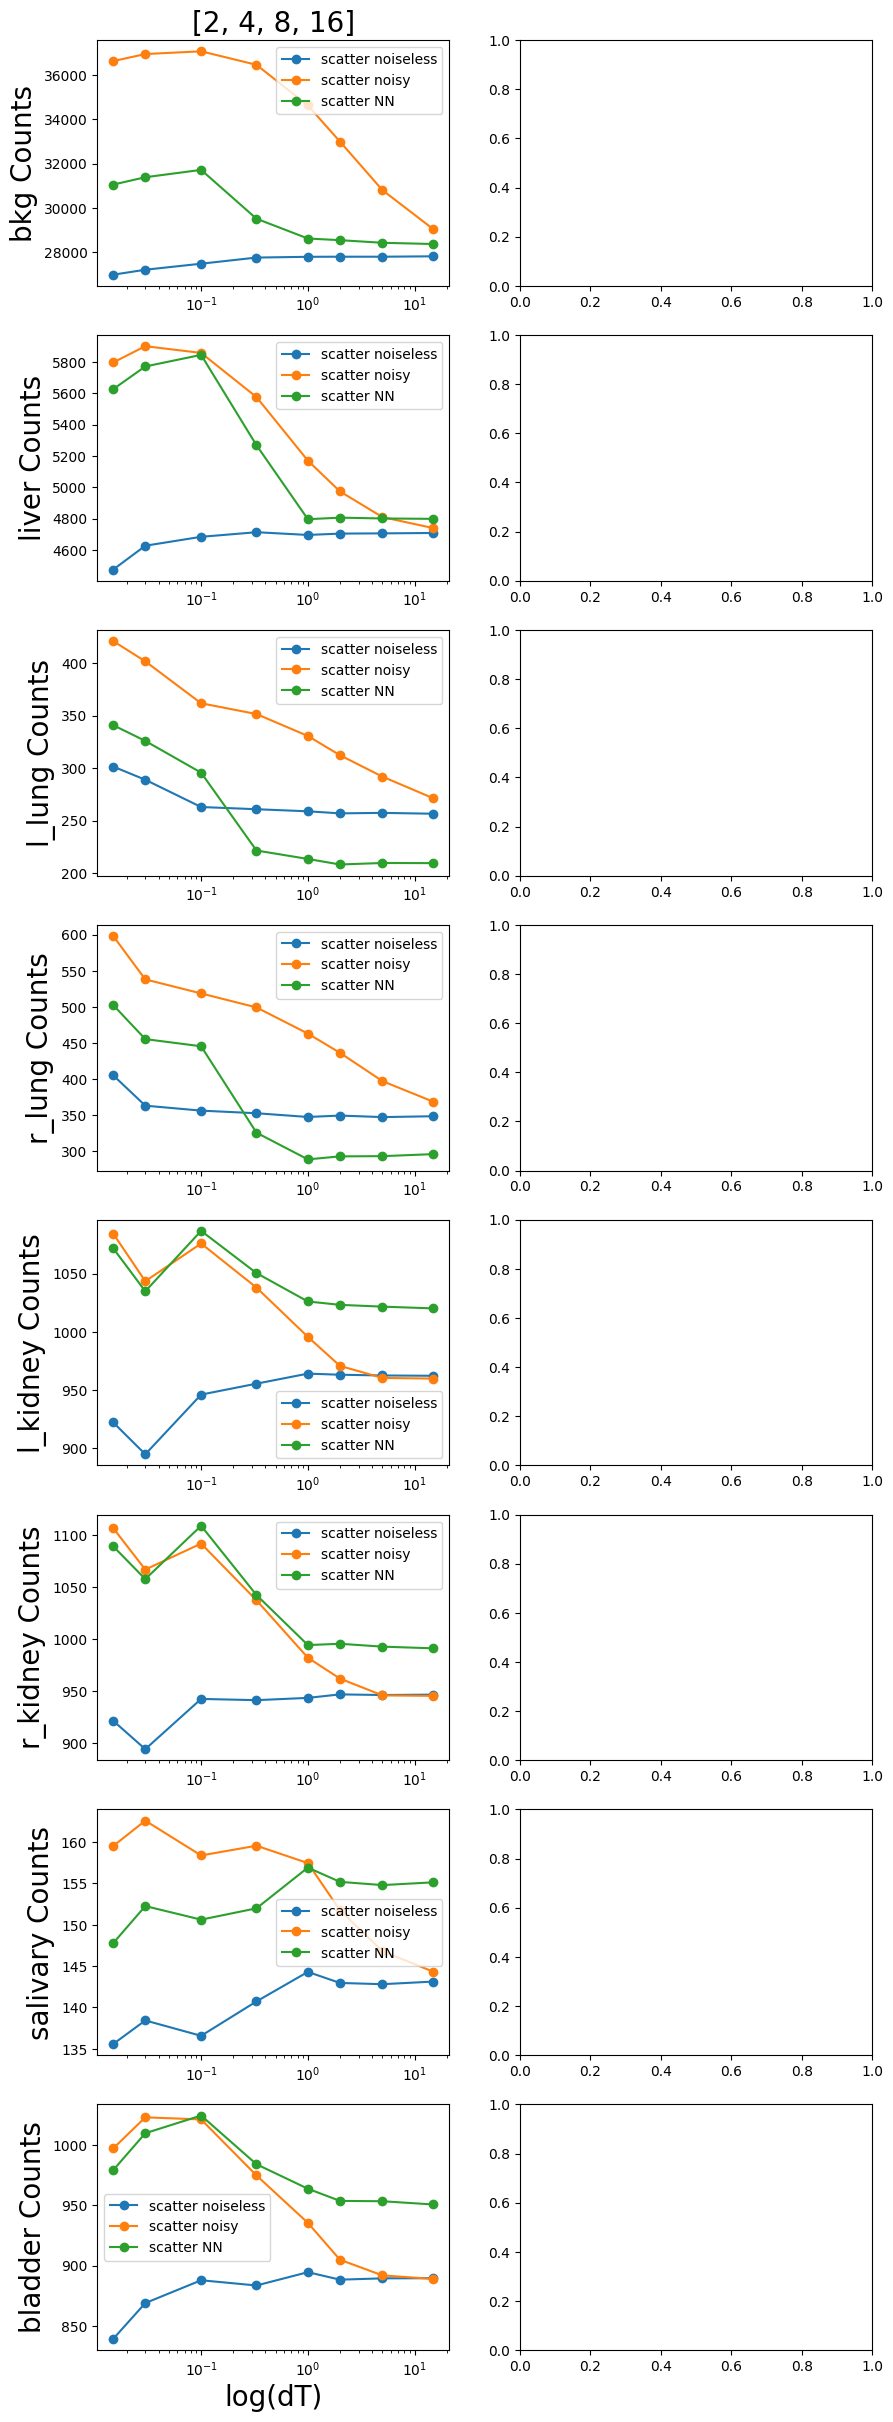

In [5]:
organ_mask_fpath = '/home/sahamed/Projects/pytomography/scatter-estimation-deep-image-prior/ground_truth/organ_mask.pt'
organ_mask = torch.load(organ_mask_fpath)

fig, ax = plt.subplots(8, 2, figsize=(10, 30))

for i in range(len(organs)):
    for j in range(len(exp_codes)):
        plot_noiseless_noisy_pred_counts_for_a_network_and_organ(organs[i], exp_codes[j], organ_mask, ax=ax[i][j])



In [ ]:
t = 0.015
exp_code = 'unet_2x4x8x16'
recon_scatter_noiseless_list, recon_scatter_noisy_list, recon_scatter_pred_list = [],[],[]
for run in range(20):
    recon_scatter_noiseless, recon_scatter_noisy, recon_scatter_pred = load_reconstructed_images(t, exp_code, run, input_type='NoiseInput')
    recon_scatter_noiseless_list.append(recon_scatter_noiseless)
    recon_scatter_noisy_list.append(recon_scatter_noisy)
    recon_scatter_pred_list.append(recon_scatter_pred)
    

In [ ]:
m = np.mean(recon_scatter_noiseless_list)

In [ ]:
result_mean = np.mean(np.stack(recon_scatter_noiseless_list, axis=0), axis=0)


In [ ]:
result_mean.shape

In [ ]:
bkg_mask = (organ_mask == 1).astype(np.uint8)
plt.pcolormesh(bkg_mask[:,70,:].T)